In [1]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Success Prediction
- Predict success or not with information given before project begins
- Features : target_money, grammar_level, has_video, funding_type_count, funding_type_1, funding_type_2, funding_type_3, funding_duration


### ※ Estimation of grammar_level
- number of errors / number of tokens
- tested by *naver grammar tester* (https://github.com/ssut/py-hanspell)
- suppposed grammar level represents ability of creators

## Outline
- Check the insight from previous project (https://github.com/surprisoh/crowdfunding_prediction)
- Distribution test
- Feature selection
- Model Selection (classification)
- Grid Search & Scores
- Optimum model selection
- Result & Insight

## 1. Distribution Test

In [2]:
#load_data
cf_df = pd.read_excel('cf_df.xlsx')

In [3]:
#check feature number
def check_number(feature):
    """"feature : 'str'"""
    count = cf_df[feature].value_counts()
    return print(count)

In [4]:
# success rate
print('overall success'),
print('=================='),
success_percentage = cf_df['end_with_success'].value_counts()[1] / cf_df['end_with_success'].count()
print(round(success_percentage*100, 2),'%' )

overall success
62.34 %


### A. Percentage distribution

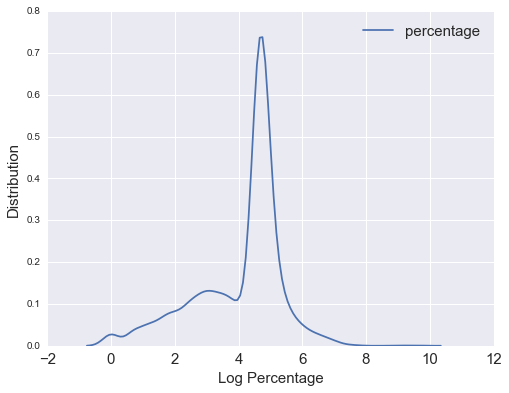

In [5]:
# percentage distribution
#log scailing
plt.figure(figsize=(8, 6))
sns.kdeplot(cf_df['percentage'].apply(lambda x: np.log(x)));
plt.legend(fontsize = 15);
plt.xticks(fontsize=15);
plt.xlabel('Log Percentage', fontsize=15);
plt.ylabel('Distribution', fontsize=15);

## B. Category

In [6]:
check_number('category')

publishing           420
music                298
design               278
movie/video          269
game                 249
art                  228
theater              138
comics               107
photo                 73
comics publishing     48
tech                  44
fashion               40
dance                 18
etc                    2
Name: category, dtype: int64


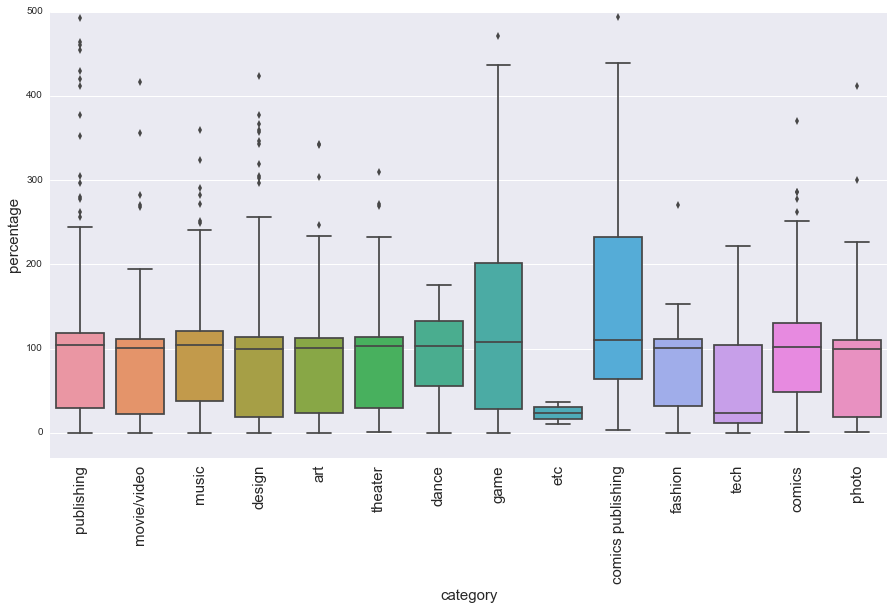

In [7]:
# percentage boxplot by categories
figure = plt.figure(figsize=(15,8))
sns.boxplot(x = cf_df['category'], y = cf_df['percentage']);
plt.xticks(rotation = 'vertical');
plt.ylim(-30, 500);
plt.xticks(fontsize=15);
plt.xlabel('category', fontsize=15);
plt.ylabel('percentage', fontsize=15);

In [8]:
# success rate by categories
print('Success rate'),
print('=================='),
for i in cf_df['category'].unique():
    success_percentage = (len(cf_df.loc[cf_df['category'] == i][cf_df['end_with_success'] == True]) / \
    len(cf_df.loc[cf_df['category'] == i]))*100
    print("{category} :".format(category = i), round(success_percentage, 2),'%')
print('=================='),
print('Dance has the highest rate')

Success rate
publishing : 65.48 %
movie/video : 62.45 %
music : 70.47 %
design : 52.52 %
art : 59.65 %
theater : 71.74 %
dance : 72.22 %
game : 59.84 %
etc : 0.0 %
comics publishing : 70.83 %
fashion : 50.0 %
tech : 36.36 %
comics : 69.16 %
photo : 53.42 %
Dance has the highest rate


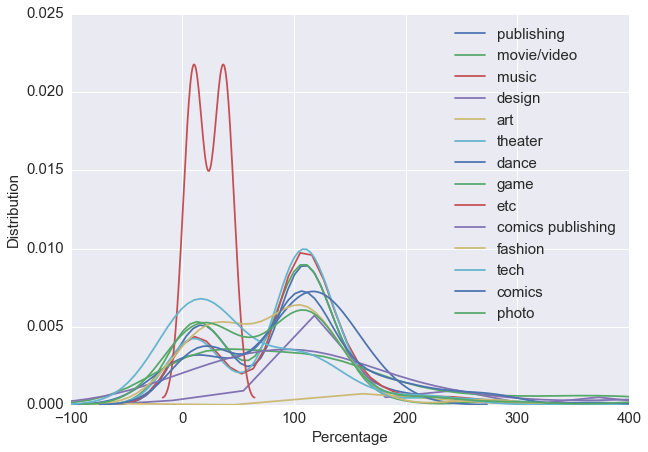

In [9]:
# category percentage distribution
figure = plt.figure(figsize=(10,7))
for i in cf_df['category'].unique():
    sns.kdeplot(cf_df.loc[cf_df['category'] == '{i}'.format(i=i)]['percentage'], label = '{i}'.format(i=i))
    plt.xlim(-100, 400);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Percentage', fontsize=15)
plt.ylabel('Distribution', fontsize=15)
plt.legend(fontsize = 15);

In [10]:
# distribution test between whole distribution and each category distribution
# K-S : Kolmogorov Smirnov test
for i in cf_df['category'].unique()[:-1]:
    all_data = cf_df['funding_rate']
    category_data = cf_df.loc[cf_df['category'] == i]['funding_rate']
    # output values (p-value < 0.05)
    if round(sp.stats.ks_2samp(all_data, category_data)[1], 4) < 0.05:
        print('[all_sample vs {category_i}]'.format(category_i = i)),
        print('  K-S statistic :', round(sp.stats.ks_2samp(all_data, category_data)[0], 4))
        print('  p-value :', round(sp.stats.ks_2samp(all_data, category_data)[1], 4))

[all_sample vs movie/video]
  K-S statistic : 0.0988
  p-value : 0.0172
[all_sample vs music]
  K-S statistic : 0.0876
  p-value : 0.0334
[all_sample vs design]
  K-S statistic : 0.0997
  p-value : 0.0136
[all_sample vs game]
  K-S statistic : 0.2137
  p-value : 0.0
[all_sample vs comics publishing]
  K-S statistic : 0.2354
  p-value : 0.0089
[all_sample vs tech]
  K-S statistic : 0.2955
  p-value : 0.0008


- Categories are classified by categories

### C. Video

In [11]:
# video by category
print('video'),
print('=================='),
for i in cf_df['category'].unique():
    video = (len(cf_df.loc[cf_df['category'] == i][cf_df['has_video'] == True]) / \
    len(cf_df.loc[cf_df['category'] == i]))*100
    print("{category} :".format(category = i), round(video, 2),'%')
overall = len(cf_df.loc[cf_df['has_video'] == True]) / len(cf_df)
print('overall :', round(overall, 2)*100, '%')

video
publishing : 25.0 %
movie/video : 60.59 %
music : 50.34 %
design : 27.34 %
art : 26.75 %
theater : 39.86 %
dance : 66.67 %
game : 32.93 %
etc : 50.0 %
comics publishing : 12.5 %
fashion : 22.5 %
tech : 38.64 %
comics : 4.67 %
photo : 21.92 %
overall : 34.0 %


In [12]:
# number 0f video
check_number('has_video')

False    1454
True      758
Name: has_video, dtype: int64


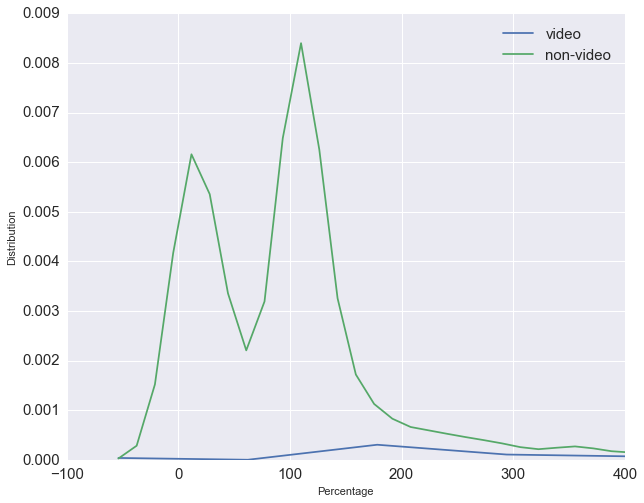

In [13]:
# percentage distribution by video status
figure = plt.figure(figsize=(10,8))
sns.kdeplot(cf_df[cf_df['has_video'] == True]['percentage'], label= 'video')
sns.kdeplot(cf_df[cf_df['has_video'] == False]['percentage'], label= 'non-video')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Percentage')
plt.ylabel('Distribution')
plt.xlim(-100, 400)
plt.legend(fontsize = 15)

In [14]:
# normality test
video_percent = cf_df[cf_df['has_video'] == True]['percentage']
no_video_percent = cf_df[cf_df['has_video'] == False]['percentage']
print('[video vs no_video]'),
print('Shapiro test statistics(video) :', sp.stats.shapiro(video_percent)[0],
'  ','Shapiro test p-value(video) :', sp.stats.shapiro(video_percent)[1])
print('Shapiro test statistics(no_video) :', sp.stats.shapiro(no_video_percent)[0],
'  ','Shapiro test p-value(no_video) :', sp.stats.shapiro(no_video_percent)[1])

[video vs no_video]
Shapiro test statistics(video) : 0.07845711708068848    Shapiro test p-value(video) : 0.0
Shapiro test statistics(no_video) : 0.5601882934570312    Shapiro test p-value(no_video) : 0.0


In [15]:
print(sp.stats.ks_2samp(video_percent, no_video_percent))
print(sp.stats.mannwhitneyu(video_percent, no_video_percent))

Ks_2sampResult(statistic=0.063222917037160653, pvalue=0.03562431845949008)
MannwhitneyuResult(statistic=551498.0, pvalue=0.97582000149086479)


- It has non normality distribution.
- Different Distribution, Same mean.

### D. Target money

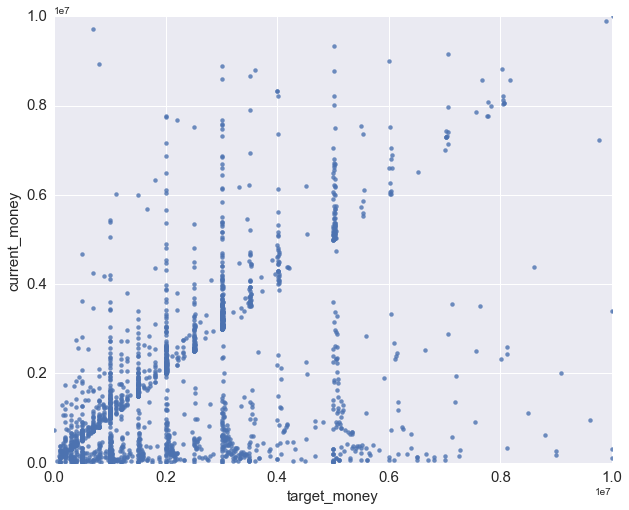

In [16]:
# target_money, current_money
figure = plt.figure(figsize=(10,8))
sns.regplot(x ='target_money', y ='current_money', data = cf_df, fit_reg=False);
plt.xlim(-1000, 10000000);
plt.ylim(-2000, 10000000);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('target_money', fontsize = 15);
plt.ylabel('current_money', fontsize = 15);

In [17]:
#Pearson Correlation
target_current_corr = sp.stats.pearsonr(cf_df['target_money'].tolist(), cf_df['current_money'].tolist())
print('Pearson correlation :', round(target_current_corr[0], 4))

Pearson correlation : 0.3636


- Target_money and result are correlated

### E. Grammar level

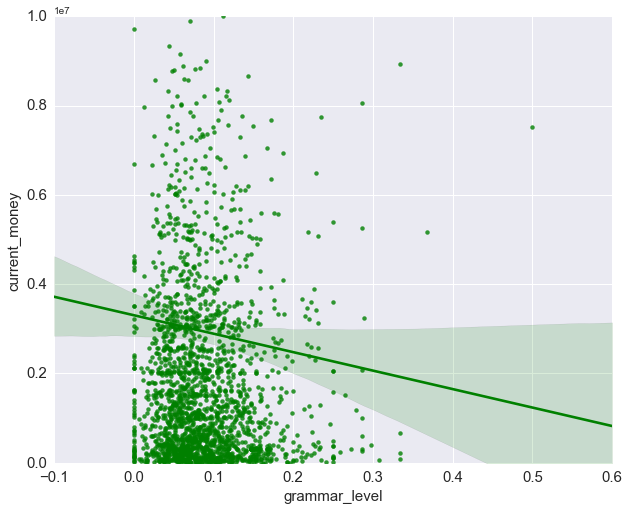

In [18]:
figure = plt.figure(figsize=(10,8));
sns.regplot(cf_df['grammar_level'], cf_df['current_money'], color='g');
plt.ylim(-1000, 10000000);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('grammar_level', fontsize = 15);
plt.ylabel('current_money', fontsize = 15);

In [19]:
#Pearson Correlation
grammar_current_corr = sp.stats.pearsonr(cf_df['grammar_level'].tolist(), cf_df['current_money'].tolist())
print('Pearson correlation :', round(grammar_current_corr[0], 4))

Pearson correlation : -0.0347


- very weak negative correlation

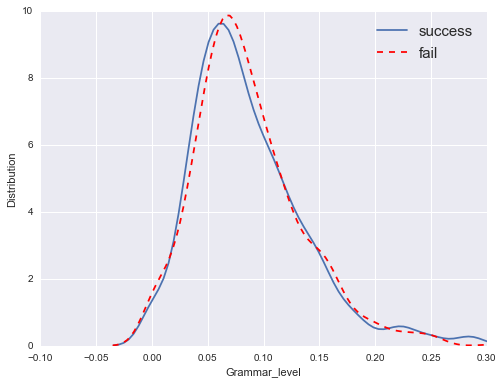

In [20]:
# distribution
figure = plt.figure(figsize=(8,6))
sns.kdeplot(cf_df[cf_df['end_with_success'] == True]['grammar_level'], label= 'success');
sns.kdeplot(cf_df[cf_df['end_with_success'] == False]['grammar_level'], label= 'fail',
            c='r', linestyle='--');
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.xlabel('Grammar_level');
plt.ylabel('Distribution');
plt.xlim(-0.1, 0.3);
plt.legend(fontsize = 15);

In [21]:
success_grammar = cf_df[cf_df['end_with_success'] == True]['grammar_level']
fail_grammar = cf_df[cf_df['end_with_success'] == False]['grammar_level']
print('Shapiro test statistics(success_grammar) :', round(sp.stats.shapiro(success_grammar)[0], 4),
'  ','Shapiro test p-value(success_grammar) :', round(sp.stats.shapiro(success_grammar)[1], 4)),
print('Shapiro test statistics(fail_grammar) :', round(sp.stats.shapiro(fail_grammar)[0], 4),
'  ','Shapiro test p-value(fail_grammar) :', round(sp.stats.shapiro(fail_grammar)[1], 4))

Shapiro test statistics(success_grammar) : 0.8984    Shapiro test p-value(success_grammar) : 0.0
Shapiro test statistics(fail_grammar) : 0.943    Shapiro test p-value(fail_grammar) : 0.0


In [22]:
print(sp.stats.ks_2samp(success_grammar, fail_grammar))
print(sp.stats.mannwhitneyu(success_grammar, fail_grammar))

Ks_2sampResult(statistic=0.038506773267682703, pvalue=0.41761203150318038)
MannwhitneyuResult(statistic=565210.0, pvalue=0.52986405927622593)


- no normality distribution
- same distribution, same mean (between success sample and fail sample)

### F. Num_funding_type

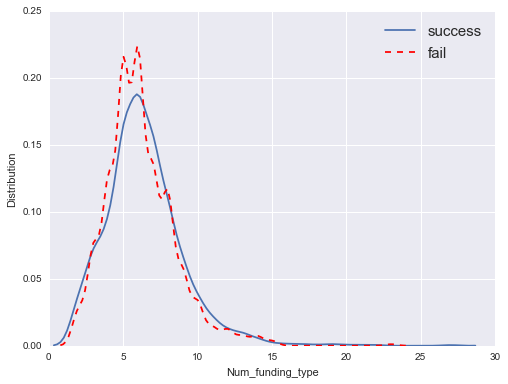

In [23]:
figure = plt.figure(figsize=(8,6))
sns.kdeplot(cf_df[cf_df['end_with_success'] == True]['num_funding_type'], label= 'success');
sns.kdeplot(cf_df[cf_df['end_with_success'] == False]['num_funding_type'], label= 'fail',
            c='r', linestyle='--');
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.xlabel('Num_funding_type');
plt.ylabel('Distribution');
#plt.xlim(-0.1, 0.3);
plt.legend(fontsize = 15);

In [24]:
success_count = cf_df[cf_df['end_with_success'] == True]['num_funding_type']
fail_count = cf_df[cf_df['end_with_success'] == False]['num_funding_type']
print('Shapiro test statistics(success_count) :', round(sp.stats.shapiro(success_count)[0], 4),
'  ','Shapiro test p-value(success_count) :', round(sp.stats.shapiro(success_count)[1], 4)),
print('Shapiro test statistics(fail_count) :', round(sp.stats.shapiro(fail_count)[0], 4),
'  ','Shapiro test p-value(fail_count) :', round(sp.stats.shapiro(fail_count)[1], 4))

Shapiro test statistics(success_count) : 0.9089    Shapiro test p-value(success_count) : 0.0
Shapiro test statistics(fail_count) : 0.9212    Shapiro test p-value(fail_count) : 0.0


In [25]:
print(sp.stats.ks_2samp(success_count, fail_count))
print(sp.stats.mannwhitneyu(success_count, fail_count))

Ks_2sampResult(statistic=0.06290028701836059, pvalue=0.031391504587808421)
MannwhitneyuResult(statistic=606632.0, pvalue=0.019369818590031399)


- no normality distribution
- different distribution, different mean (between success sample and fail sample)

### G. Month

In [26]:
check_number('start_month')

11    267
10    220
12    218
9     213
1     209
7     199
8     188
2     175
6     163
5     140
3     132
4      88
Name: start_month, dtype: int64


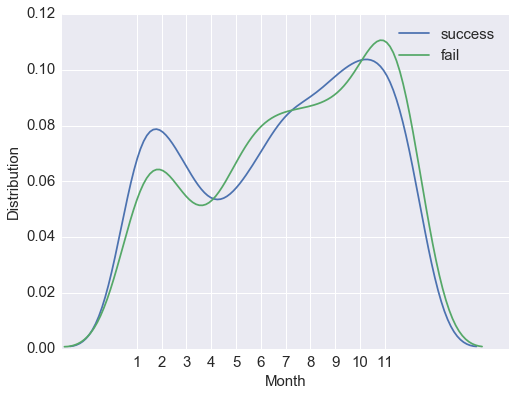

In [27]:
plt.figure(figsize=(8,6));
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==True]['start_month'], label = 'success');
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==False]['start_month'], label = 'fail');
plt.xticks(range(1, 12), fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Month', fontsize=15);
plt.ylabel('Distribution', fontsize = 15);
plt.legend(fontsize = 15);

In [28]:
# Ks_2sampResult : Kolmogorov-Smirnov test
# Ttest_indResult : 2 sample T-test
success_month = cf_df.loc[cf_df['end_with_success'] ==True]['start_month']
fail_month = cf_df.loc[cf_df['end_with_success'] ==False]['start_month']
print(sp.stats.ks_2samp(success_month, fail_month))
print(sp.stats.ttest_ind(success_month, fail_month))

Ks_2sampResult(statistic=0.052869878916033397, pvalue=0.10624009393771351)
Ttest_indResult(statistic=-2.3759975226000387, pvalue=0.017586367162689347)


- same distribution, different mean (between success sample and fail sample)

### H. Funding_duration

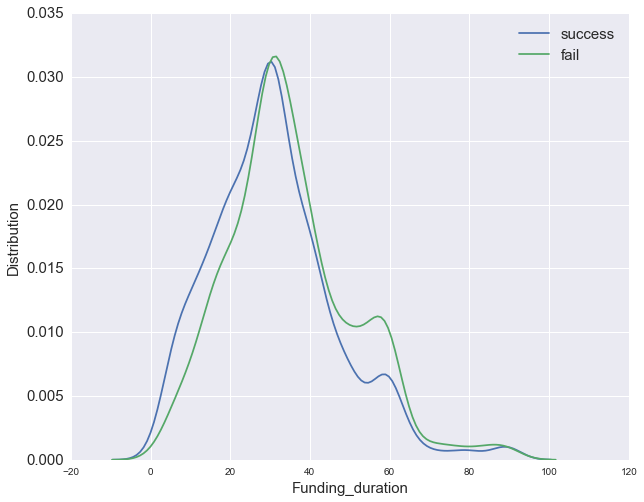

In [29]:
plt.figure(figsize=(10,8));
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==True]['funding_duration'], label = 'success');
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==False]['funding_duration'], label = 'fail');
plt.yticks(fontsize=15);
plt.xlabel('Funding_duration', fontsize=15);
plt.ylabel('Distribution', fontsize = 15);
plt.legend(fontsize = 15);

In [30]:
# Ks_2sampResult : Kolmogorov-Smirnov test
# Ttest_indResult : 2 sample T-test
success_duration = cf_df.loc[cf_df['end_with_success'] ==True]['funding_duration']
fail_duration = cf_df.loc[cf_df['end_with_success'] ==False]['funding_duration']
print(sp.stats.ks_2samp(success_duration, fail_duration))
print(sp.stats.ttest_ind(success_duration, fail_duration))

Ks_2sampResult(statistic=0.12289992138987577, pvalue=2.5890164134690636e-07)
Ttest_indResult(statistic=-5.9479039022936844, pvalue=3.1490116777196017e-09)


- different distribution, different mean (between success sample and fail sample)

***Label Encoding***

In [31]:
from sklearn.preprocessing import LabelEncoder

In [32]:
le = LabelEncoder()

In [33]:
cf_df['category_label'] = le.fit_transform(cf_df['category'])

In [34]:
category_class = le.classes_
category_class

array(['art', 'comics', 'comics publishing', 'dance', 'design', 'etc',
       'fashion', 'game', 'movie/video', 'music', 'photo', 'publishing',
       'tech', 'theater'], dtype=object)

## 2. Feature selection
- According to proeject result, incorrent feaure selection leads to high variance of accuracy
- We treat this part importantly
- 앞서 실시했던 project의 결과, 잘못된 feature의 선택은 accuracy를 크게 변화시키는 경향을 보인다.
- feature selection 방법론을 중요하게 다룰 것임

### A. Variables Selection

In [35]:
# all features
x = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video'], cf_df['grammar_level'],
                 cf_df['start_month'], cf_df['funding_duration'],
                 cf_df['num_funding_type']]).T

In [36]:
#no month, duration, num_funding_type
x_grammar = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video'], cf_df['grammar_level']]).T

In [37]:
#no month, duration, num_funding_type, grammar
x_no_grammar = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video']]).T

In [38]:
y = cf_df['end_with_success']

### B. SelectKBest
- Univariate feature selection
    - Univariate feature selection works by selecting the best features based on univariate statistical tests
- Removes all but the K-highest scoring features
- Scoring Function
    - f_classif : Compute the ANOVA F-value for the provided sample.


In [39]:
x_kbest = SelectKBest(f_classif, k=4).fit_transform(x, y)
x_kbest

array([[  2.00442500e+06,   0.00000000e+00,   5.00000000e+00,
          5.00000000e+01],
       [  5.00294100e+06,   1.00000000e+00,   5.00000000e+00,
          9.00000000e+01],
       [  1.00000000e+06,   1.00000000e+00,   5.00000000e+00,
          6.00000000e+01],
       ..., 
       [  1.00040700e+06,   0.00000000e+00,   3.00000000e+00,
          1.90000000e+01],
       [  4.67058800e+06,   0.00000000e+00,   3.00000000e+00,
          4.00000000e+01],
       [  1.00000000e+05,   0.00000000e+00,   3.00000000e+00,
          2.00000000e+00]])

* when using k=4, (***target_money, funding_duration, start_month, has_video***) are selected

### C. Correlation

In [40]:
x_categories = pd.DataFrame([x['category_label'], x['has_video'], x['start_month']]).T
x_nominal = pd.DataFrame([x['target_money'], x['grammar_level'], x['funding_duration'],
                         x['num_funding_type']]).T

                category_label  has_video  start_month
category_label        1.000000   0.077431    -0.093077
has_video             0.077431   1.000000    -0.060863
start_month          -0.093077  -0.060863     1.000000


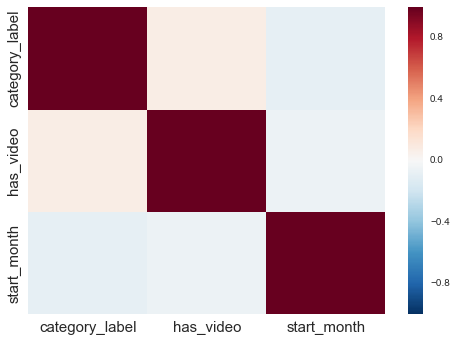

In [41]:
category_corr = x_categories.corr(method='spearman')
print(category_corr);
sns.heatmap(category_corr);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);

                  target_money  grammar_level  funding_duration  \
target_money          1.000000      -0.070147          0.298985   
grammar_level        -0.070147       1.000000         -0.087444   
funding_duration      0.298985      -0.087444          1.000000   
num_funding_type      0.129247      -0.050219          0.186218   

                  num_funding_type  
target_money              0.129247  
grammar_level            -0.050219  
funding_duration          0.186218  
num_funding_type          1.000000  


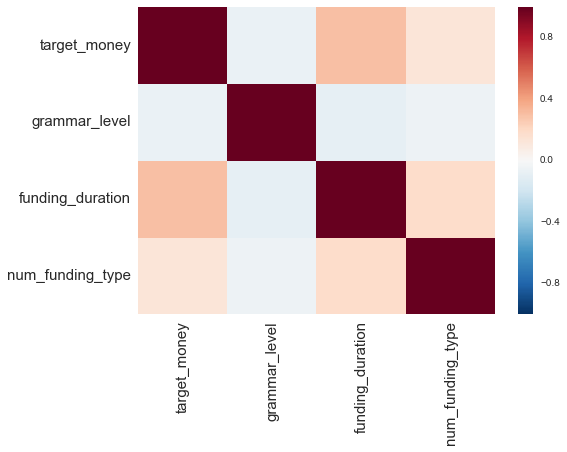

In [42]:
nominal_corr = x_nominal.corr(method='pearson')
print(nominal_corr)
sns.heatmap(nominal_corr);
plt.xticks(fontsize = 15, rotation='vertical');
plt.yticks(fontsize = 15);

- As a result, ***(target_money, funding_duration, num_funding_type)*** are highly correlated
- According to correlation theory, one variable could be used among ***(target_money, funding_duration, num_funding_type)***
- Candidates are ***target_money, grammar_level, category_label, has_video, start_month***

### D. Feature Importance (Random Forest)
- Ease of use
- Relatively good accuracy
- Robustness

In [43]:
re = RandomForestClassifier()

In [44]:
re.fit(x, y)
feature_importance = pd.DataFrame()
for i in np.arange(len(x.columns)):
    if re.feature_importances_[i] >= 0.1:
        fi = pd.DataFrame([x.columns[i], re.feature_importances_[i]], 
                          index = ['features', 'importance']).T
        feature_importance = feature_importance.append(fi)

feature_importance.index = np.arange(len(feature_importance))
feature_importance

,features,importance
0,category_label,0.105509
1,target_money,0.29702
2,grammar_level,0.190312
3,start_month,0.120083
4,funding_duration,0.171659


- *** target_money, grammar_level, funding_duration, start_month*** are selected
- But it's always changed as model fits

### E. Mean decrease accuracy
- Directly measure the impact of each feature on accuracy of the model
- For unimportant variables, the permutation should have little to no effect on model accuracy
- Base model = RandomForest

In [45]:
from sklearn.cross_validation import ShuffleSplit
from collections import defaultdict

re_1 = RandomForestClassifier(n_estimators=20)
scores = defaultdict(list)
names = x.columns

#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(x), 20, .3):
    X_train, X_test = x.ix[train_idx], x.ix[test_idx]
    Y_train, Y_test = y.ix[train_idx], y.ix[test_idx]
    r = re.fit(X_train, Y_train)
    acc = re.score(X_test, Y_test)
    for i in x.columns:
        X_drop_train = X_train.drop([i], axis=1)
        X_drop_test = X_test.drop([i], axis=1)
        re_1.fit(X_drop_train, Y_train)
        shuff_acc = round(re_1.score(X_drop_test, Y_test), 4)
        scores[i].append(round((acc-shuff_acc)/acc, 4))

print ("Features sorted by their score:"),
print (pd.DataFrame([sorted([(feat, round(np.mean(score), 4)) for feat, score in scores.items()], 
                            reverse=True)], index = ['score']).T)

Features sorted by their score:
                         score
0       (target_money, 0.0947)
1       (start_month, -0.0597)
2  (num_funding_type, -0.0389)
3         (has_video, -0.0466)
4     (grammar_level, -0.0475)
5  (funding_duration, -0.0614)
6    (category_label, -0.0442)


- (-) score means accuracy increases without a variable
- Only ***target_money*** is selected

### F. RFE (Recursive Feature Estimation)
- Repeatedly construct a model and choose either the best or worst performing feature 
- Base model = RandomForest

In [46]:
from sklearn.feature_selection import RFE

In [47]:
names = x.columns
 
rfe = RFE(re)
rfe.fit(x, y)
 
print ("Features sorted by their rank"),
pd.DataFrame([sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))], 
             index=['Ranking']).T

Features sorted by their rank


,Ranking
0,"(1, funding_duration)"
1,"(1, grammar_level)"
2,"(1, target_money)"
3,"(2, start_month)"
4,"(3, num_funding_type)"
5,"(4, category_label)"
6,"(5, has_video)"


### G. # Result

- Kbest = ***target_money, funding_duration, start_month, has_video***
- Correlation = ***target_money, grammar_level, start_month, has_video, category_label***
- Feature Importance =  ***target_money, grammar_level, funding_duration, start_month***
- Mean decrese accuracy = ***target_money***
- Reculsive Feature Estimation =  ***target_money, grammar_level, funding_duration, start_month, category_label***
- Rank : ***target_money > start_month > grammar_level > funding_duration > category_label = has_video***

- 'num_funding_type' may be unimportant
- Final Selection
    - 4 features : target_money, start_month, grammar_level, funding_duration
    - 5 features : target_money, start_month, grammar_level, funding_duration, category_label(or has_video)

## 3. Model Selection (Classification)
- SVC
- Gaussian Naive Bayes
- Decision Tree 
- Random Forest
- Select models show better performance than base success rate (62.34%)

In [48]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

In [49]:
# using features
x_4 = pd.DataFrame([cf_df['target_money'], cf_df['start_month'],
                           cf_df['grammar_level'], cf_df['funding_duration']]).T
x_5 = pd.DataFrame([cf_df['target_money'], cf_df['start_month'],
                           cf_df['grammar_level'], cf_df['funding_duration'], 
                           cf_df['category_label']]).T

In [50]:
success_percentage = y.value_counts()[1] / len(y)
print('Base success rate:' ,round(success_percentage * 100, 2),'%')

Base success rate: 62.34 %


### A. SVC

In [51]:
svc_rbf = SVC(kernel = 'rbf')

In [52]:
#SVC kernel : rbf
print('7 features :', cross_val_score(svc_rbf, x, y).mean()),
print('=======================================================')
print('5 features : ', cross_val_score(svc_rbf, x_5, y).mean()),
print('======================================================='),
print('4 features : ', cross_val_score(svc_rbf, x_4, y).mean())

7 features : 0.622060455206
5 features :  0.621607556655
4 features :  0.631549232159


- As features reduce, score increases

### B. GaussianNB

In [53]:
gnb = GaussianNB()

In [54]:
# GNB
print('7 features :', cross_val_score(gnb, x, y).mean()),
print('=======================================================')
print('5 features : ', cross_val_score(gnb, x_5, y).mean()),
print('======================================================='),
print('4 features : ', cross_val_score(gnb, x_4, y).mean())

7 features : 0.629289648875
5 features :  0.629289648875
4 features :  0.629289648875


### C. Decision Tree

In [55]:
dt = DecisionTreeClassifier(criterion = 'entropy')

In [56]:
# DecisionTree
print('7 features :', cross_val_score(dt, x, y).mean()),
print('=======================================================')
print('5 features : ', cross_val_score(dt, x_5, y).mean()),
print('======================================================='),
print('4 features : ', cross_val_score(dt, x_4, y).mean())

7 features : 0.669080898237
5 features :  0.678592995169
4 features :  0.686267723184


### D. Radom Forest

In [57]:
rf = RandomForestClassifier(n_estimators=20)

In [58]:
# Random Forest
print('7 features :', cross_val_score(rf, x, y).mean()),
print('=======================================================')
print('5 features : ', cross_val_score(rf, x_5, y).mean()),
print('======================================================='),
print('4 features : ', cross_val_score(rf, x_4, y).mean())

7 features : 0.654623738266
5 features :  0.649656582617
4 features :  0.680857487923


### E. KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
knn = KNeighborsClassifier()

In [61]:
print('7 features :', cross_val_score(knn, x, y).mean()),
print('=======================================================')
print('5 features : ', cross_val_score(knn, x_5, y).mean()),
print('======================================================='),
print('4 features : ', cross_val_score(knn, x_4, y).mean())

7 features : 0.761317554299
5 features :  0.759966222851
4 features :  0.767644632968


### F. Model comparison

In [62]:
#StratifiedKFold : proper method for binary classes
sfkfold = StratifiedKFold(y, n_folds = 10)

In [63]:
"""3 scores """
def scores(model, x_1, x_2, x_3, y, cv):
    scores = [cross_val_score(model, x_1, y, cv=cv).mean(),
              cross_val_score(model, x_2, y, cv=cv).mean(),
              cross_val_score(model, x_3, y, cv=cv).mean()]
    return scores

In [64]:
svc_score = scores(svc_rbf, x_4, x_5, x, y, sfkfold)
dt_score = scores(dt,x_4, x_5, x, y, sfkfold)
rf_score = scores(rf, x_4, x_5, x, y, sfkfold)
knn_score = scores(knn, x_4, x_5, x, y, sfkfold)
gnb_score = scores(gnb, x_4, x_5, x, y, sfkfold)

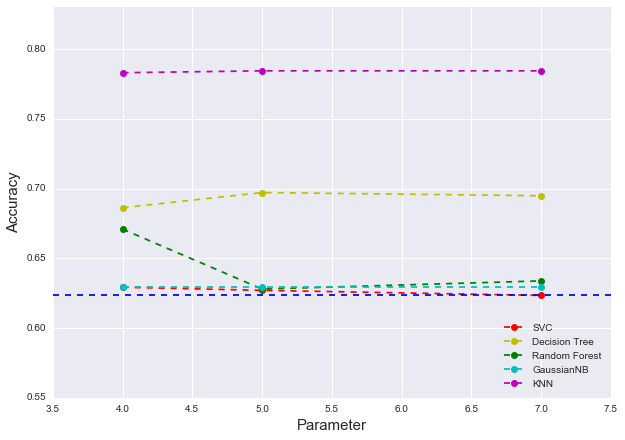

In [65]:
figure = plt.figure(figsize=(10,7));
x_ticks = [len(x_4.columns), len(x_5.columns), len(x.columns)]
plt.plot(x_ticks, svc_score, 'o--', c='r', label = 'SVC');
plt.plot(x_ticks, dt_score, 'o--', c='y', label = 'Decision Tree');
plt.plot(x_ticks, rf_score, 'o--', c='g', label = 'Random Forest');
plt.plot(x_ticks, gnb_score, 'o--', c='c', label = 'GaussianNB');
plt.plot(x_ticks, knn_score, 'o--', c='m', label = 'KNN');
plt.legend(loc = 'lower right');
plt.xlabel('Parameter', fontsize=15);
plt.axhline(y = success_percentage, ls = '--', c='b');
plt.ylabel('Accuracy', fontsize=15);
plt.ylim(0.55, 0.83);
plt.xlim(3.5, 7.5);

- ***Decision Tree, Random Forest, KNN*** are selected

## 3. Grid Search & Score
- ***Decision Tree*** : Accuracy flucuates as selected features changed
    - Parameter tuning, Feature selection
- ***Random Forest*** : Accuracy flucuates as selected features changed
    - Parameter tuning, Feture selection
- ***KNN*** : Accuracy flucuates as selected features changed
    - Parameter tuning

In [66]:
from sklearn.grid_search import GridSearchCV

In [67]:
# Gridsearch report function
from operator import itemgetter
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

### A. Decision Tree
- x_features = 'target_money', 'start_month', 'grammar_level', 'funding_duration'

In [68]:
#Decision Tree parameters
param_grid = {"max_depth": [3, 5, None],
              "max_features": ['auto','sqrt', None],
              "min_samples_split": np.arange(1, 5),
              "min_samples_leaf": [1, 3, 5, 10]}

# run grid search
grid_search = GridSearchCV(dt, param_grid=param_grid)
grid_search.fit(x_4, y)

report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.724 (std: 0.016)
Parameters: {'max_features': None, 'max_depth': None, 'min_samples_split': 1, 'min_samples_leaf': 10}

Model with rank: 2
Mean validation score: 0.724 (std: 0.016)
Parameters: {'max_features': None, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10}

Model with rank: 3
Mean validation score: 0.724 (std: 0.016)
Parameters: {'max_features': None, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 10}



### B. Random Forest

In [69]:
# Random Forest parameters
param_grid = {"min_samples_leaf": [1, 2, 3],
             "n_estimators" : np.arange(2, 50),
             "criterion" : ["gini", "entropy"],
             "bootstrap" : [True, False]}

# run grid search
grid_search = GridSearchCV(rf, param_grid=param_grid)
grid_search.fit(x_4, y)

report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.711 (std: 0.007)
Parameters: {'min_samples_leaf': 3, 'criterion': 'gini', 'n_estimators': 42, 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.710 (std: 0.009)
Parameters: {'min_samples_leaf': 3, 'criterion': 'entropy', 'n_estimators': 32, 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.709 (std: 0.007)
Parameters: {'min_samples_leaf': 3, 'criterion': 'gini', 'n_estimators': 41, 'bootstrap': True}



### C. KNN

In [70]:
# KNN parameters
param_grid = {"n_neighbors": np.arange(1, 20)}

# run grid search
grid_search = GridSearchCV(knn, param_grid=param_grid)
grid_search.fit(x_4, y)

report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.768 (std: 0.011)
Parameters: {'n_neighbors': 5}

Model with rank: 2
Mean validation score: 0.767 (std: 0.017)
Parameters: {'n_neighbors': 3}

Model with rank: 3
Mean validation score: 0.764 (std: 0.005)
Parameters: {'n_neighbors': 9}



### D. Pluctuation as a parameter change
- Random Forest, KNN
- KNN parameter = n_neighbors
- Random Forest parameter = n_estimators

Random Forest max_accuracy : 68.58 %
KNN max_accuracy : 78.94 %


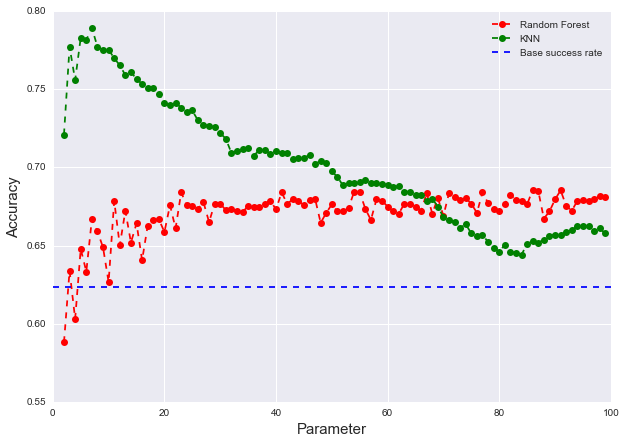

In [71]:
# Random Forest, KNN
x_model = []
rf_model = []
knn_model = []
figure = plt.figure(figsize=(10,7))
for i in range(2, 100):
    knn_score = cross_val_score(KNeighborsClassifier(n_neighbors=i), x_4, y, cv=sfkfold).mean()    
    rf_score = cross_val_score(RandomForestClassifier(n_estimators=i), x_4, y, cv=sfkfold).mean()    
    x_model.append(i)
    rf_model.append(rf_score)
    knn_model.append(knn_score)

plt.plot(x_model, rf_model, 'o--', c='r', label = 'Random Forest')
plt.plot(x_model, knn_model, 'o--', c='g', label = 'KNN')
plt.xlabel('Parameter', fontsize=15)
plt.axhline(y = success_percentage, ls = '--', c='b', label = 'Base success rate')
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
print('Random Forest max_accuracy :', round(max(rf_model)*100, 2), '%'),
print('KNN max_accuracy :', round(max(knn_model)*100, 2), '%')

## 4. Optimum models

### A. Classification Report

In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import auc

In [73]:
# optimum models
best_knn = KNeighborsClassifier(n_neighbors=5)
best_dt = DecisionTreeClassifier(max_depth= None, min_samples_leaf= 10, min_samples_split= 1, max_features= None)
best_rf = RandomForestClassifier(n_estimators=42, bootstrap=True, min_samples_leaf= 3, criterion ='gini')

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [75]:
best_knn.fit(x_train, y_train);
best_rf.fit(x_train, y_train);
best_dt.fit(x_train, y_train);

In [76]:
print('Success : True'),
print('Fail : False')
print('')
print("[KNN Classification_report]"),
print(classification_report(y_test, best_knn.predict(x_test))),
print("===================================================="),
print("[Random Forest Classification_report]"),
print(classification_report(y_test, best_rf.predict(x_test))),
print("===================================================="),
print("[Decision Tree Classification_report]"),
print(classification_report(y_test, best_dt.predict(x_test)))

Success : True
Fail : False

[KNN Classification_report]
             precision    recall  f1-score   support

      False       0.77      0.58      0.66       156
       True       0.80      0.91      0.85       287

avg / total       0.79      0.79      0.78       443

[Random Forest Classification_report]
             precision    recall  f1-score   support

      False       0.61      0.33      0.43       156
       True       0.71      0.89      0.79       287

avg / total       0.68      0.69      0.66       443

[Decision Tree Classification_report]
             precision    recall  f1-score   support

      False       0.65      0.65      0.65       156
       True       0.81      0.81      0.81       287

avg / total       0.75      0.75      0.75       443



## 5. Result

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

Acrual result vs predicted result


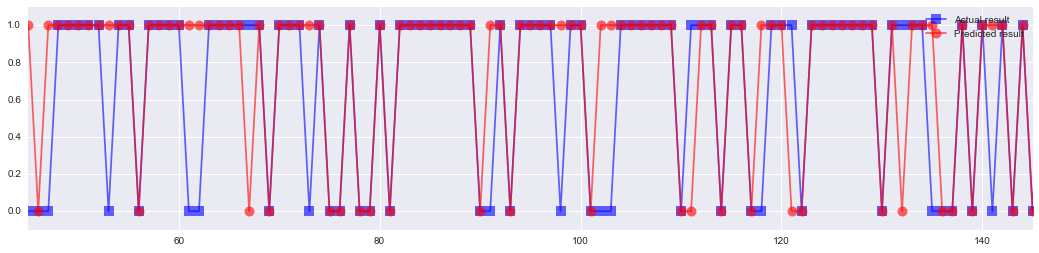

In [79]:
# plot
plt.figure(figsize=(18,4))
plt.plot(y, 'bs-', markersize=10, alpha=0.6, label="Actual result")
plt.plot(best_knn.predict(x), 'ro-', markersize=10, alpha=0.6, label="Predicted result")
plt.legend()
plt.xlim(45, 145);
plt.ylim(-0.1, 1.1);
print('Acrual result vs predicted result')

- Overall, performance of KNN is the best (Accuracy : 0.78, Recall : 0.79)
- We have to intepret the result carefully. Because this report is conducted with few features(4) and samples(2000+), and all samples are gathered for 5 years(2011~). It may have overfitting and time parameters' affection. 
- But still, KNN performs amazingly, even if KNN is ease of use and optimal value(k) is highly data-dependent

### Insight

- Grammar level is estimated with project description (In previouse project, it was comments)
- Grmmar level, date duration effects in this case
- I expect grammar level represens project creator's qualification or user's annoyance index
- Number of funding type (range of choice) doesn't really matter (some samples only have 2 type, but others have over 5types)
- ***Key figure of success is still quality of a project***
- To predict perfectly, crowd funding company must make measurable index of quality

#### Appendix : with grammar vs with no grammar

max_accuracy(with_grammar_level) : 73.6 %
max_accuracy(no_grammar_level) : 70.88 %


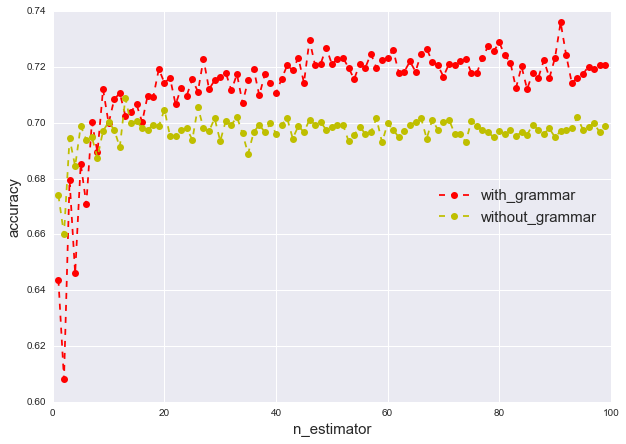

In [80]:
x_no_grammars = []
y_no_grammars = []
x_grammars = []
y_grammars = []

x_no_grammar = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video']]).T
x_grammar = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video'], cf_df['grammar_level']]).T

figure = plt.figure(figsize=(10, 7))
legend =['with_grammar', 'without_grammar'] 
for i in range(1, 100):
    rf_grammar = RandomForestClassifier(n_estimators=i)
    grammar_score = cross_val_score(rf_grammar, x_grammar, y, cv=10).mean()
    x_grammars.append(i)
    y_grammars.append(grammar_score)

for i in range(1, 100):
    rf_no_grammar = RandomForestClassifier(n_estimators=i)
    no_grammar_score = cross_val_score(rf_no_grammar, x_no_grammar, y, cv=10).mean()
    x_no_grammars.append(i)
    y_no_grammars.append(no_grammar_score)

plt.plot(x_grammars, y_grammars, 'o--', c='r', label = 'with grammar')
plt.plot(x_no_grammars, y_no_grammars, 'o--', c = 'y', label = 'with no grammar')
plt.legend(legend, loc=5, fontsize=15)
plt.xlabel('n_estimator', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
print('max_accuracy(with_grammar_level) :', round(max(y_grammars)*100, 2), '%'),
print('max_accuracy(no_grammar_level) :', round(max(y_no_grammars)*100, 2), '%')

- Random Forest performs better with grammar level feature